# Libraries

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime, date
from sklearn.metrics import r2_score

# Input data - dropping date and bitcoin opening, high and low prices

In [17]:
data = pd.read_csv('/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')

In [18]:
data['Date'] = pd.to_datetime(data['Date'])

In [19]:
data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,Active Addr Cnt,Xfer Cnt,Mean Tx Size (native units),Total Fees (USD),...,RUB,Tweets,Google,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2015-08-07,278.740997,280.391998,276.365997,279.584991,42484800.0,283150,497302,2.057514,7235.134845,...,64.480003,47467,90.000000,0,0,0,0,1,0,0
1,2015-08-08,279.742004,279.928009,260.709991,260.997009,58533000.0,266587,284532,3.675623,5806.842316,...,64.480003,29031,91.578947,0,0,0,0,0,1,0
2,2015-08-09,261.115997,267.002991,260.467987,265.083008,23789600.0,262571,276720,4.201519,4952.554125,...,64.480003,27132,91.578947,0,0,0,0,0,0,1
3,2015-08-10,265.477997,267.032013,262.596008,264.470001,20979400.0,292834,304538,3.463212,7563.840456,...,64.480003,27744,96.315789,1,0,0,0,0,0,0
4,2015-08-11,264.342010,270.385986,264.093994,270.385986,25433900.0,271613,280398,3.785274,7128.842169,...,62.889999,26653,104.210526,0,1,0,0,0,0,0


In [20]:
data.shape

(2430, 48)

In [21]:
data.isna().sum()

Date                           0
BTC_Open                       0
BTC_High                       0
BTC_Low                        0
BTC_Close                      0
BTC_Volume                     0
Active Addr Cnt                0
Xfer Cnt                       0
Mean Tx Size (native units)    0
Total Fees (USD)               0
Mean Hash Rate                 0
Difficulty                     0
Mean Block Size (in bytes)     0
Sum Block Weight               0
LTC                            0
XRP                            0
DASH                           0
DOGE                           0
ETH                            0
Gold                           0
Silver                         0
Copper                         0
Oil                            0
Treasury Yield 10 Years        0
S&P500                         0
DJI                            0
CBOE                           0
NASDAQ                         0
JP225                          0
CSI300                         0
DXY       

# Split data into train and test set

In [22]:
start_day_p2 = pd.Timestamp(2018, 10, 1)
test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period2 = data[(data["Date"] <= end_day_p2)].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)
train_dataset_p2 = train_dataset_p2.drop(columns = ["Date"])
test_dataset_p2 = test_dataset_p2.drop(columns = ["Date"])

In [23]:
# Define the target variable
target = 'BTC_Close'

# Create the feature sets
X_train = train_dataset_p2[:-1]
X_test = test_dataset_p2[:-1]

# Create the target sets
Y_train = train_dataset_p2[target][1:]
Y_test = test_dataset_p2[target][1:]

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (2246, 47)
X_test shape: (182, 47)
Y_train shape: (2246,)
Y_test shape: (182,)


# Normalize data with MinMaxScaler

In [24]:
# Normalize the datasets using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Update the variables used for training
X_train = X_train_scaled
X_test = X_test_scaled

print(len(X_train))

2246


# Model initialization & compilation

In [25]:
import keras_tuner as kt


def mlp_builder(hp):
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
    hp_no_layers = hp.Int('no_layers', min_value=1, max_value=2, step=1)
    for i in range(hp_no_layers):
        hp_no_units = hp.Choice(f'no_units_{i}', values=[64, 128, 256])
        model.add(tf.keras.layers.Dense(units=hp_no_units, activation='relu'))
        hp_no_dropout = hp.Float(
            f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(tf.keras.layers.Dropout(hp_no_dropout))
    hp_last_units = hp.Choice('last_units', values=[64, 128, 256])
    model.add(tf.keras.layers.Dense(units=hp_last_units, activation='relu'))
    hp_last_dropout = hp.Float(
        'last_dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(hp_last_dropout))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model


tuner = kt.Hyperband(mlp_builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     directory='/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/implementations/hyperparam_tuning',
                     project_name='mlp_p2')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
tuner.search(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), callbacks=[stop_early])

Trial 254 Complete [00h 00m 16s]
val_loss: 16352233.0

Best val_loss So Far: 6177240.0
Total elapsed time: 00h 41m 33s


In [27]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), callbacks=[stop_early])
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f"Best epoch: {best_epoch}")

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 290221824.0000 - val_loss: 1184416768.0000
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110599776.0000 - val_loss: 360291936.0000
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42259264.0000 - val_loss: 72991696.0000
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13428701.0000 - val_loss: 51557252.0000
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11941735.0000 - val_loss: 23688496.0000
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9629791.0000 - val_loss: 16842688.0000
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8409588.0000 - val_loss: 18643914.0000
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7706263.0000 - val_loss: 15050333.0000
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7110950.0000 - val_loss: 16110963.0000
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6713365.0000 - val_loss: 11008942.0000
Epoch 11/

In [28]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train, Y_train, epochs=best_epoch)

Epoch 1/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 292111808.0000
Epoch 2/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114913584.0000
Epoch 3/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53167480.0000
Epoch 4/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14202494.0000
Epoch 5/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12646143.0000
Epoch 6/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10301504.0000
Epoch 7/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9752023.0000 
Epoch 8/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7018325.5000
Epoch 9/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7036313.5000
Epoch 10/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6436654.5000
Epoch 11/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8033234.0000
Epoch 12/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5198209.5000
Epoch 13/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5692687.5000
Epoch 14/34
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56956

In [29]:
# Plot the result
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100

Y_pred = hypermodel.predict(X_test)
r2 = r2_score(Y_test, Y_pred)
rmse = root_mean_squared_error(Y_test, Y_pred)
da = directional_accuracy(Y_test, Y_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


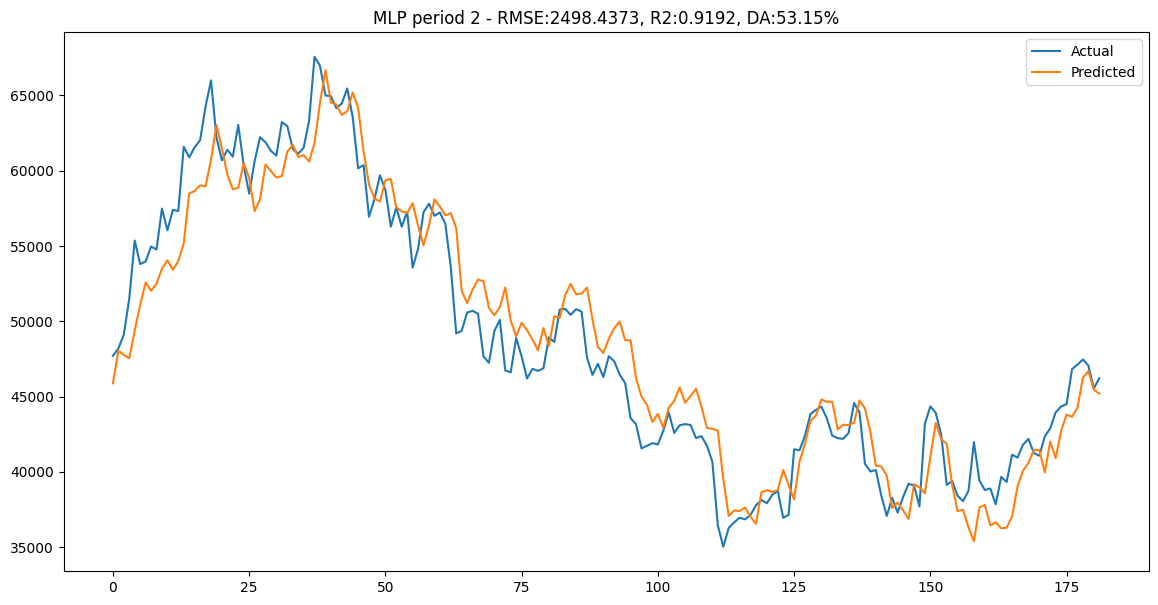

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.title(f"MLP period 2 - RMSE:{rmse:.4f}, R2:{r2:.4f}, DA:{da:.2f}%")
plt.plot(Y_test, label='Actual')
plt.plot(Y_pred, label='Predicted')

plt.legend()
plt.show()

In [31]:
print(best_hps.values)

{'no_layers': 2, 'no_units_0': 256, 'dropout_0': 0.4, 'last_units': 256, 'last_dropout': 0.1, 'no_units_1': 256, 'dropout_1': 0.5, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0142'}
